In [7]:
import pandas as pd

# for drawing map
import geopandas as gpd
import matplotlib.pyplot as plt

import folium
from shapely.geometry import Point

<Axes: >

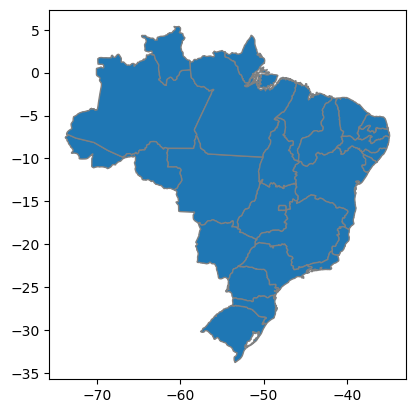

In [8]:
geometry = gpd.read_file("GeoJson/data/Brasil.json")
geometry.plot(edgecolor = "gray")

In [9]:
geometry.head()

,UF,ESTADO,REGIAO,geometry
0,AC,Acre,NO,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1..."
1,AL,Alagoas,NE,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4..."
2,AP,Amapá,NO,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ..."
3,AM,Amazonas,NO,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251..."
4,BA,Bahia,NE,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537..."


In [10]:
def read_csv(file):
    return pd.read_csv(f"DataSet2/{file}.csv", dtype={'zip_code': str})
    
geo = read_csv("geo")
customers = read_csv("customers")
sellers = read_csv("sellers")

### Where are our customer located?
Analysing in state level

In [11]:
customers.shape

(99441, 5)

In [16]:
customers_summarize = customers.groupby("state").size().reset_index()
customers_summarize.columns = ['state', 'count']
customers_summarize.head()

,state,count
0,AC,81
1,AL,413
2,AM,148
3,AP,68
4,BA,3380


In [13]:
customers_summarize['count'].sum()

np.int64(99441)

In [17]:
customer_map = pd.merge(geometry, customers_summarize, left_on='UF', right_on="state", how='inner')

# Create a copy of the geometry using EPSG:3857 
geometry_3857 = customer_map.geometry.to_crs(epsg = 3857)

# Print the area in kilometers squared
sqm_to_sqkm = 10**6 # 10^6
area = geometry_3857.area / sqm_to_sqkm
customer_map['area'] = area

# Find the center point for Markers/PopUps
customer_map['center'] = geometry_3857.centroid.to_crs(epsg = 4236)

# Find the customer density
customer_map['density'] = customer_map.apply(lambda row: row['count'] / row.area , axis = 1) 
customer_map.head()

,UF,ESTADO,REGIAO,geometry,state,count,area,center,density
0,AC,Acre,NO,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",AC,81,1.546121e+05,POINT (-70.44565 -9.33281),0.000524
1,AL,Alagoas,NE,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",AL,413,2.805746e+04,POINT (-36.61065 -9.50338),0.014720
2,AP,Amapá,NO,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",AP,68,1.381140e+05,POINT (-51.9383 1.44925),0.000492
3,AM,Amazonas,NO,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",AM,148,1.604026e+06,POINT (-64.66208 -4.2071),0.000092
4,BA,Bahia,NE,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",BA,3380,5.861974e+05,POINT (-41.66166 -12.49308),0.005766


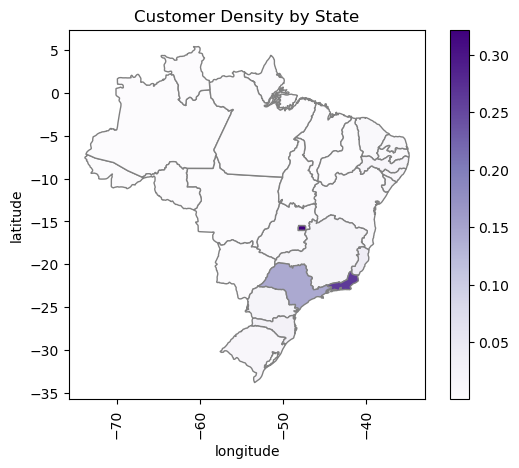

In [18]:
# Polished choropleth of building permit_density
customer_map.plot(column = 'density', cmap = 'Purples', edgecolor= 'grey', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('Customer Density by State')
plt.show();

In [29]:
pp = pd.read_csv("DataSet2/population_states_2022.csv")

In [30]:
pp_map = pd.merge(geometry, pp, left_on='UF', right_on="state_id", how='inner')
pp_map.head()

,UF,ESTADO,REGIAO,geometry,population,state_id,state_name
0,AC,Acre,NO,"POLYGON ((-68.61895 -11.12971, -68.68534 -11.1...",830018,AC,Acre
1,AL,Alagoas,NE,"POLYGON ((-36.43149 -10.44823, -36.47339 -10.4...",3127683,AL,Alagoas
2,AP,Amapá,NO,"MULTIPOLYGON (((-51.90932 -1.16579, -51.96526 ...",733759,AP,Amapá
3,AM,Amazonas,NO,"POLYGON ((-63.47887 2.19845, -63.43955 2.09251...",3941613,AM,Amazonas
4,BA,Bahia,NE,"MULTIPOLYGON (((-45.95923 -14.89726, -45.93537...",14141626,BA,Bahia


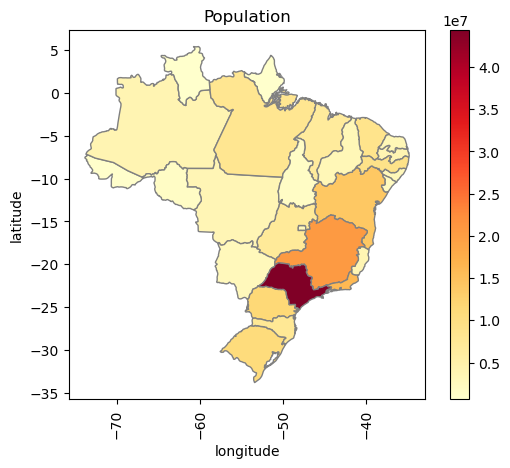

In [34]:
# Polished choropleth of building permit_density
pp_map.plot(column = 'population', cmap = 'YlOrRd', edgecolor= 'grey', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('Population')
plt.show();

In [19]:
# Center point for Nashville
brazil = [-14.2350, -51.9253] 

# Create map
m = folium.Map(location=brazil, zoom_start=4)

#Density Layer
folium.Choropleth(
    geo_data=geometry,
    name='Density',
    data=customer_map,
    columns=['id', 'density'],
    key_on='feature.properties.id',
    fill_color= 'Purples',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Customer per km squared'
).add_to(m)
folium.LayerControl().add_to(m)

# Build markers and popups
for row in customer_map.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = (row_values['name'] + 
             ', Density: ' + str(round(row_values['density'], 2))+ 
             ', Total Customers: ' + str(row_values['count']))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
display(m)

KeyError: "None of ['id'] are in the columns"

In [ ]:
# Polished choropleth of building permit_density
customer_map.plot(column = 'count', cmap = 'Oranges', edgecolor= 'grey', legend = True)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('Customer Count by State')
plt.show();

In [ ]:
# Center point for Nashville
brazil = [-14.2350, -51.9253] 

# Create map
tc = folium.Map(location=brazil, zoom_start=4)

#Density Layer
folium.Choropleth(
    geo_data=geometry,
    name='Total Customers',
    data=customer_map,
    columns=['id', 'count'],
    key_on='feature.properties.id',
    fill_color= 'Oranges',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Total Customers'
).add_to(tc)
folium.LayerControl().add_to(tc)

# Build markers and popups
for row in customer_map.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = (row_values['name'] + 
             ', Density: ' + str(round(row_values['density'], 2))+ 
             ', Total Customers: ' + str(row_values['count']))
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(tc)
    
# Display the map
display(tc)

### Findings
1) Most customers are located in Sao Paulo state.
2) Due to its small size, Distrito Federal has the highest customer density.
3) The state in South, and South-East have the highest customer conecntration.
4) High Priority areas are Distrito Federal, Rio de Janeiro, São Paulo.
5) Priority areas are Minas Gerais, Paraná, Santa Catarina, Rio Grande do Sul.
6) Other areas are Low Priority.

###	Seller-to-Customer Ratio

In [ ]:
sellers.shape

In [ ]:
sellers.head()

In [ ]:
sellers_summarize = sellers.groupby("zip_code").size().reset_index()
sellers_summarize.columns = ["zip_code", "count"]
sellers_summarize.sort_values(by='count', ascending=False, inplace=True)
sellers_summarize.head()

In [ ]:
#add lat, lng to sellers df
sellers_summarize = pd.merge(sellers_summarize, geo, on = "zip_code", how='left')
sellers_summarize.shape

In [ ]:
print(sellers_summarize.isnull().sum())

In [ ]:
# Polished choropleth of building permit_density
customer_map.plot(column = 'density', cmap = 'Purples', edgecolor= 'grey', legend = True)

plt.scatter(
    x=sellers_summarize.lng, 
    y=sellers_summarize.lat,
    s= sellers_summarize['count'],
    c='red')
    


plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xticks(rotation = 'vertical')
plt.title('Sellers on Map')
plt.show();